In [ ]:
# default_exp helper_functions

In [ ]:
from nbdev import *
from drcstools.helper_functions import *

# helper_functions

> read and preprocess netcdf data

In [ ]:
#export
import xarray as xr
import numpy as np
from glob import glob

In [ ]:
#export
def rotated_grid_transform(grid_in, option, SP_coor):
    """
    rotated pole
    """
    
    pi = np.pi
    lon = grid_in[0]
    lat = grid_in[1];

    lon = (lon*pi)/180; # Convert degrees to radians
    lat = (lat*pi)/180;

    SP_lon = SP_coor[0];
    SP_lat = SP_coor[1];
    
    SP_lon = SP_lon - 180
    SP_lat = -SP_lat

    theta = 90+SP_lat; # Rotation around y-axis
    phi = SP_lon; # Rotation around z-axis

    theta = (theta*pi)/180;
    phi = (phi*pi)/180; # Convert degrees to radians

    x = np.cos(lon)*np.cos(lat); # Convert from spherical to cartesian coordinates
    y = np.sin(lon)*np.cos(lat);
    z = np.sin(lat);

    if option == 1: # Regular -> Rotated

        x_new = np.cos(theta)*np.cos(phi)*x + np.cos(theta)*np.sin(phi)*y + np.sin(theta)*z;
        y_new = -np.sin(phi)*x + np.cos(phi)*y;
        z_new = -np.sin(theta)*np.cos(phi)*x - np.sin(theta)*np.sin(phi)*y + np.cos(theta)*z;

    else:  # Rotated -> Regular

        phi = -phi;
        theta = -theta;

        x_new = np.cos(theta)*np.cos(phi)*x + np.sin(phi)*y + np.sin(theta)*np.cos(phi)*z;
        y_new = -np.cos(theta)*np.sin(phi)*x + np.cos(phi)*y - np.sin(theta)*np.sin(phi)*z;
        z_new = -np.sin(theta)*x + np.cos(theta)*z;

    lon_new = np.arctan2(y_new,x_new); # Convert cartesian back to spherical coordinates
    lat_new = np.arcsin(z_new);

    lon_new = (lon_new*180)/pi; # Convert radians back to degrees
    lat_new = (lat_new*180)/pi;

    return lon_new , lat_new

In [ ]:
#export
def transform_calendar(ds,
                       timedim="time",
                       calendarname="proleptic_gregorin"):
    """Transforms calendar of time index in xarray dataset"""
    ds[timedim].attrs['calendar'] = calendarname
    return ds

In [ ]:
show_doc(transform_calendar)

<h4 id="transform_calendar" class="doc_header"><code>transform_calendar</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>transform_calendar</code>(**`ds`**, **`timedim`**=*`'time'`*, **`calendarname`**=*`'proleptic_gregorin'`*)

Transforms calendar of time index in xarray dataset

Use in combination with `xr.open_dataset([...], decode_time=False)`

Args:
- ds (object): xarray dataset

Kwargs:

- timedim (string): name of time dim
- calendarname (string): calendar name

Returns: 
- ds (xarray dataset)


In [ ]:
#export
def read_netcdfs(files, dim, transform_func, transform_calendar=None):
    """Reads multiples netcdfs files. Should be used when open_mfdatasets is to slow."""
    def process_one_path(path):
        if transform_calendar is not None:
            calendar = False
        else:
            calendar = True
        with xr.open_dataset(path, decode_times = calendar, use_cftime = True) as ds:
            if transform_calendar is not None:
                ds[dim].attrs['calendar'] = transform_calendar
                ds = xr.decode_cf(ds)
            if transform_func is not None:
                ds = transform_func(ds)
            ds.load()
            return ds
    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

In [ ]:
show_doc(read_netcdfs)

<h4 id="read_netcdfs" class="doc_header"><code>read_netcdfs</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>read_netcdfs</code>(**`files`**, **`dim`**, **`transform_func`**, **`transform_calendar`**=*`None`*)

Reads multiples netcdfs files. Should be used when open_mfdatasets is to slow.

Args:
- files : Path to files (str)
- dim : dimension to concat files (if transform_calendar=T, concat along time)
- transform_func : additional preprocessing option
- transform_calendar : name of calendar (see function transform_calendar())

Returns:
- combined netcdf files as xarray object

Example:

```python
combined =  read_netcdfs("/silod5/boergel/tmp.nc", dim = "TIME",
                transform_func=lambda ds:ds.salt,
                transform_calendar="proleptic_gregorian")
```

In [ ]:
#export
def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""

    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})

    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [ ]:
show_doc(adjust_lon_lat)

<h4 id="adjust_lon_lat" class="doc_header"><code>adjust_lon_lat</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>adjust_lon_lat</code>(**`ds`**, **`lon_name`**, **`lat_name`**, **`reverse`**=*`False`*)

Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude.

Args:
- ds (xarray): xarray Dataset
- lon_name (str): name of longitude in ds
- lat_name (str): name of latitude in ds 
- reverse (bool): if True latitude is reversed

Returns: 
- ds (xarray)  

In [ ]:
#export
def measure(lat1, lon1, lat2, lon2):
    """Calculates area of lon-lat grid cell in $m^2$"""
    R = 6378.137
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 1000

In [ ]:
show_doc(measure)

<h4 id="measure" class="doc_header"><code>measure</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>measure</code>(**`lat1`**, **`lon1`**, **`lat2`**, **`lon2`**)

Calculates area of lon-lat grid cell in $m^2$

In [ ]:
#export
def calculate_area_t(lon, lat):
    """Calculates area of lon-lat grid"""
    dlat = np.diff(lat)[0]
    dlon = np.diff(lon)[0]
    lats = lat - dlat/2
    lons = lon - dlon/2

    lats = np.append(lats, lats[-1] + dlat)
    lons = np.append(lons, lons[-1] + dlon)
    
    area_t = np.zeros((lat.size, lon.size))

    for j in range(1, len(lats)):
        for i in range(1, len(lons)):
            area_t[j-1, i-1] = measure(lats[j-1],lons[i-1],lats[j],lons[i])
            
    return area_t

In [ ]:
show_doc(calculate_area_t)

<h4 id="calculate_area_t" class="doc_header"><code>calculate_area_t</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>calculate_area_t</code>(**`lon`**, **`lat`**)

Calculates area of lon-lat grid

Args:
- lon (np.array): containing all lon coordinates
- lat (np.array): containing all lat coordinates

Returns:
- area (np.array [2d]): caculated area in m$^2$

Note: this calculation is **only** correct for grids where the tracer is in the middle of the grid cell.

In [ ]:
import xarray
ds = xr.open_dataset("data/era5.nc", use_cftime = True).isel(time = slice(0,2))

In [ ]:
lons = ds.longitude.values
lats = ds.latitude.values

In [ ]:
area_t = calculate_area_t(lon = lons, lat = lats)

In [ ]:
ds['area_t'] = (("latitude", "longitude"), area_t)

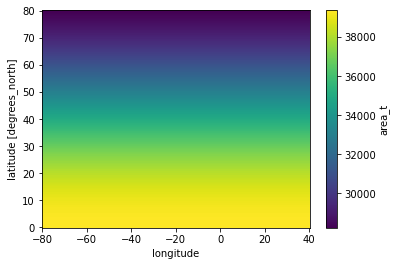

In [ ]:
ds.area_t.plot()